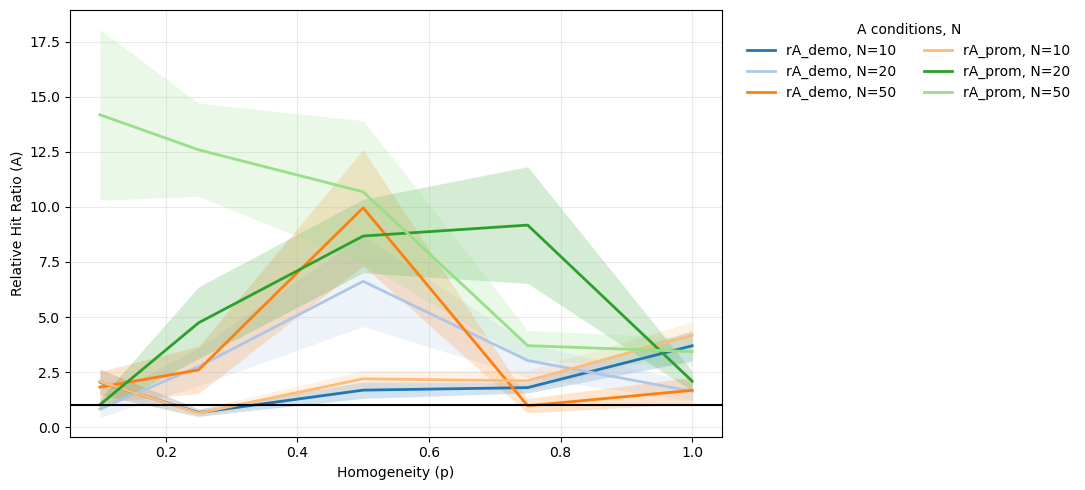

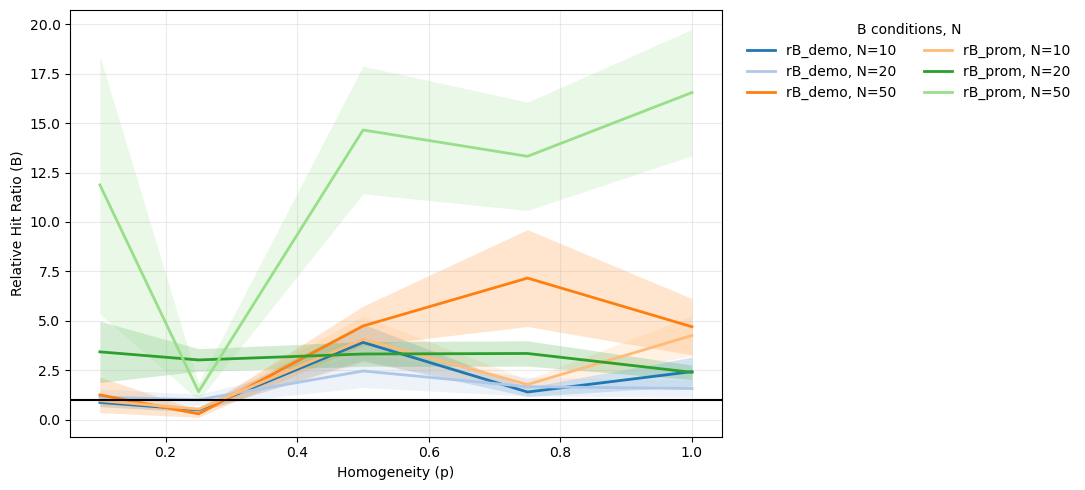

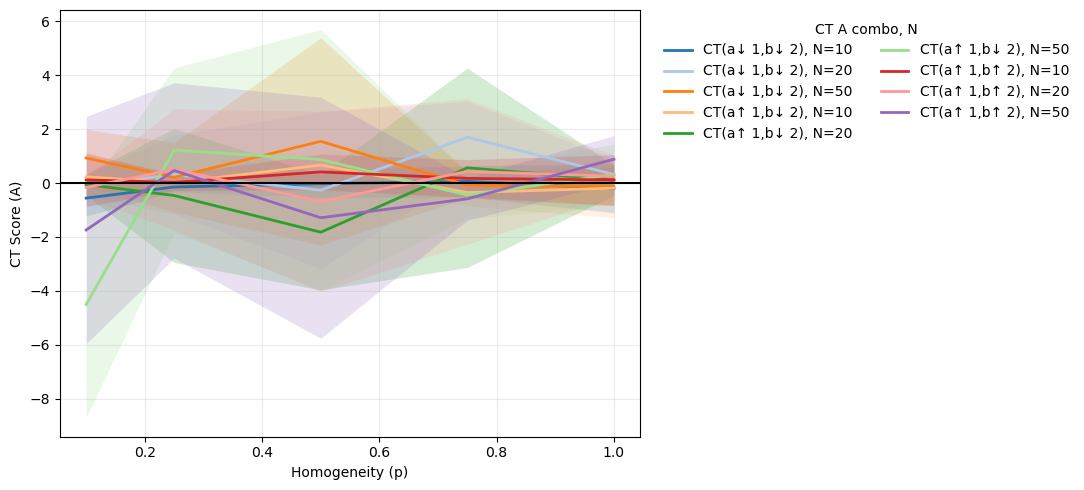

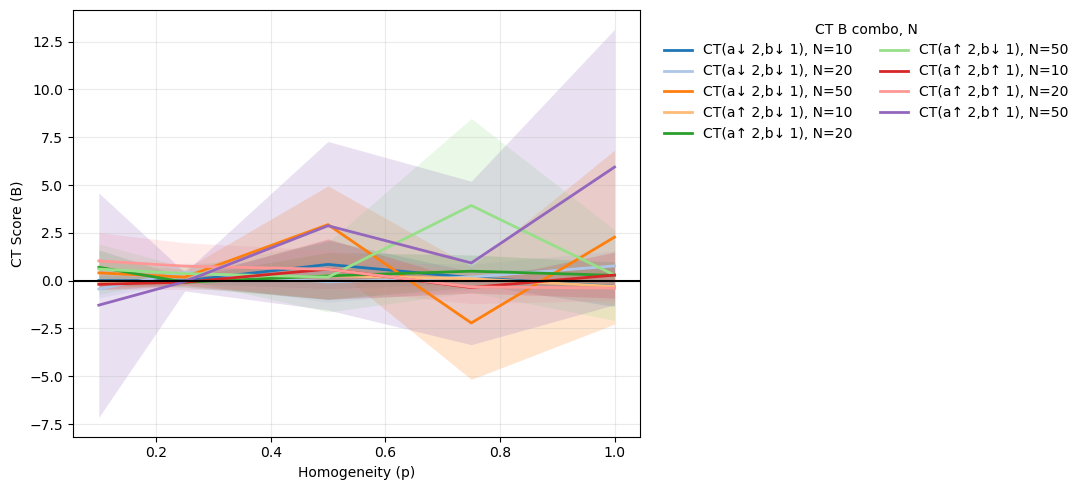

Saved figures:
 - plot_relative_hr_A_single_solid_baseline.png
 - plot_relative_hr_B_single_solid_baseline.png
 - plot_ct_A_selected_combos_solid_baseline.png
 - plot_ct_B_selected_combos_solid_baseline.png


In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

csv_path  = "rq2_results_relative_hr.csv"
p_col, n_col, trial_col = "p", "N", "trial"

# -----------------------
# Plot 1: split A and B (Relative HR)
# -----------------------
hr_cols_A = ["rA_prom", "rA_demo"]
hr_cols_B = ["rB_prom", "rB_demo"]
label_map_hr_A = {c: c for c in hr_cols_A}
label_map_hr_B = {c: c for c in hr_cols_B}

# -----------------------
# Plot 2: split A and B (selected CT combos only)
# -----------------------
ct_cols_A = ["ctA_pp","ctA_dd","ctA_pd"]
ct_cols_B = ["ctB_pp","ctB_dd","ctB_pd"]

label_map_ct_A = {
    "ctA_pp": "CT(a↑ 1,b↑ 2)",
    "ctA_dd": "CT(a↓ 1,b↓ 2)",
    "ctA_pd": "CT(a↑ 1,b↓ 2)",
}
label_map_ct_B = {
    "ctB_pp": "CT(a↑ 2,b↑ 1)",
    "ctB_dd": "CT(a↓ 2,b↓ 1)",
    "ctB_pd": "CT(a↑ 2,b↓ 1)",
}

# Filters
MAX_VAL = 20    # drop values > 20
MIN_VAL = -15   # drop values < -15

# 95% t-based CI (fallback to 1.96 if SciPy isn't available)
try:
    from scipy import stats
    def tcrit(df): return stats.t.ppf(0.975, df)
except Exception:
    def tcrit(df): return 1.96

def add_ci(df, mean_col="mean"):
    df = df.copy()
    def hw(row):
        if row["n"] > 1 and pd.notna(row["std"]):
            return tcrit(row["n"] - 1) * row["std"] / np.sqrt(row["n"])
        return np.nan
    df["halfwidth"] = df.apply(hw, axis=1)
    df["lower"] = df[mean_col] - df["halfwidth"]
    df["upper"] = df[mean_col] + df["halfwidth"]
    return df

def summarize_across_trials(df, value_cols, family_name=""):
    """
    Collapse across trials: for each (metric, N, p) compute mean, std, n, 95% CI.
    Applies value filters before aggregation.
    """
    long = df.melt(
        id_vars=[n_col, p_col, trial_col],
        value_vars=value_cols,
        var_name="metric",
        value_name="value",
    )
    long = long[(long["value"] <= MAX_VAL) & (long["value"] >= MIN_VAL)]

    agg = (long
           .groupby(["metric", n_col, p_col])["value"]
           .agg(mean="mean", std=lambda x: x.std(ddof=1), n="count")
           .reset_index())
    agg = add_ci(agg, "mean")
    agg[p_col] = pd.to_numeric(agg[p_col], errors="coerce")
    agg[n_col] = pd.to_numeric(agg[n_col], errors="coerce")
    return agg.sort_values(["metric", n_col, p_col])

def plot_family(summary, ylabel, label_map, baseline=None, outfile=None, legend_title="Condition, N"):
    s = summary.copy()
    # legend label: "<metric pretty>, N=<N>"
    s[n_col] = s[n_col].astype("Int64")
    s["series"] = s["metric"].map(label_map).fillna(s["metric"]) + ", N=" + s[n_col].astype(str)

    series_list = s["series"].unique().tolist()
    colors = plt.cm.tab20.colors
    color_map = {name: colors[i % len(colors)] for i, name in enumerate(series_list)}

    plt.figure(figsize=(11, 5))
    for name in series_list:
        sub = s[s["series"] == name].sort_values(p_col)
        x, y = sub[p_col].values, sub["mean"].values
        lo, hi = sub["lower"].values, sub["upper"].values

        c = color_map[name]
        plt.plot(x, y, label=name, linewidth=2, color=c)
        if np.isfinite(lo).any() and np.isfinite(hi).any():
            plt.fill_between(x, lo, hi, alpha=0.20, color=c, linewidth=0)

    if baseline is not None:
        plt.axhline(baseline, color="black", linewidth=1.5)

    plt.xlabel("Homogeneity (p)")
    plt.ylabel(ylabel)
    plt.grid(alpha=0.25)
    plt.legend(title=legend_title, ncol=2, bbox_to_anchor=(1.02, 1),
               loc="upper left", frameon=False)
    plt.tight_layout()
    if outfile:
        plt.savefig(outfile, dpi=300)
    plt.show()

# -----------------------
# Run
# -----------------------
df = pd.read_csv(csv_path)

# Plot 1A: Relative HR for A (baseline = 1.0)
hrA_summary = summarize_across_trials(df, hr_cols_A, family_name="HR A")
hrA_summary.to_csv("agg_relative_hr_A_by_(metric,N,p)_filtered.csv", index=False)
plot_family(
    hrA_summary,
    ylabel="Relative Hit Ratio (A)",
    label_map=label_map_hr_A,
    baseline=1.0,
    outfile="plot_relative_hr_A_single_solid_baseline.png",
    legend_title="A conditions, N",
)

# Plot 1B: Relative HR for B (baseline = 1.0)
hrB_summary = summarize_across_trials(df, hr_cols_B, family_name="HR B")
hrB_summary.to_csv("agg_relative_hr_B_by_(metric,N,p)_filtered.csv", index=False)
plot_family(
    hrB_summary,
    ylabel="Relative Hit Ratio (B)",
    label_map=label_map_hr_B,
    baseline=1.0,
    outfile="plot_relative_hr_B_single_solid_baseline.png",
    legend_title="B conditions, N",
)

# Plot 2A: CT combos for A (baseline = 0.0)
ctA_summary = summarize_across_trials(df, ct_cols_A, family_name="CT A combos")
ctA_summary.to_csv("agg_ct_A_selected_combos_by_(metric,N,p)_filtered.csv", index=False)
plot_family(
    ctA_summary,
    ylabel="CT Score (A)",
    label_map=label_map_ct_A,
    baseline=0.0,
    outfile="plot_ct_A_selected_combos_solid_baseline.png",
    legend_title="CT A combo, N",
)

# Plot 2B: CT combos for B (baseline = 0.0)
ctB_summary = summarize_across_trials(df, ct_cols_B, family_name="CT B combos")
ctB_summary.to_csv("agg_ct_B_selected_combos_by_(metric,N,p)_filtered.csv", index=False)
plot_family(
    ctB_summary,
    ylabel="CT Score (B)",
    label_map=label_map_ct_B,
    baseline=0.0,
    outfile="plot_ct_B_selected_combos_solid_baseline.png",
    legend_title="CT B combo, N",
)

print("Saved figures:")
print(" - plot_relative_hr_A_single_solid_baseline.png")
print(" - plot_relative_hr_B_single_solid_baseline.png")
print(" - plot_ct_A_selected_combos_solid_baseline.png")
print(" - plot_ct_B_selected_combos_solid_baseline.png")




In [ ]:
# Choose the condition
N_val = 20
p_val = 0.1

# Select rows matching that condition, and only keep the requested columns
subset = df.loc[
    (df["N"] == N_val) & (df["p"] == p_val),
    ["N", "p", "trial", "gA_base", "gB_base", "gA_prom", "gA_demo", "gB_prom", "gB_demo", "rA_prom", "rB_prom", "rA_demo","rB_demo"]
]
subset

,N,p,trial,gA_base,gB_base,gA_prom,gA_demo,gB_prom,gB_demo,rA_prom,rB_prom,rA_demo,rB_demo
200,50,0.1,0,0.010927,0.002483,0.248576,0.057086,0.055430,0.000248,22.748485,22.320000,5.224242,0.100000
201,50,0.1,1,0.010927,0.002483,0.214934,0.015944,0.092285,0.001060,19.669697,37.160000,1.459091,0.426667
202,50,0.1,2,0.010927,0.002483,0.341672,0.014354,0.083013,0.000248,31.268182,33.426667,1.313636,0.100000
203,50,0.1,3,0.010927,0.002483,0.206854,0.012848,0.055579,0.005033,18.930303,22.380000,1.175758,2.026667
204,50,0.1,4,0.010927,0.002483,0.193924,0.072467,0.093295,0.000497,17.746970,37.566667,6.631818,0.200000
205,50,0.1,5,0.010927,0.002483,0.223030,0.018179,0.183940,0.003858,20.410606,74.066667,1.663636,1.553333
206,50,0.1,6,0.010927,0.002483,0.182980,0.009222,0.050149,0.008940,16.745455,20.193333,0.843939,3.600000
207,50,0.1,7,0.010927,0.002483,0.265646,0.022781,0.024454,0.001904,24.310606,9.846667,2.084848,0.766667
208,50,0.1,8,0.010927,0.002483,0.221175,0.024023,0.118543,0.000613,20.240909,47.733333,2.198485,0.246667
209,50,0.1,9,0.010927,0.002483,0.233791,0.018113,0.056159,0.000977,21.395455,22.613333,1.657576,0.393333


In [23]:
subset = df[(df["N"] == 10) & (df["p"] == 0.1)]
subset

,N,p,trial,gA_base,gB_base,gA_prom,gA_demo,gB_prom,gB_demo,gA_pp,...,rA_pd,ctA_pd,rB_pd,ctB_pd,rA_dp,ctA_dp,rB_dp,ctB_dp,size_A,size_B
0,10,0.1,0,0.05,0.14553,0.244868,0.138642,0.173692,0.055199,0.037864,...,1.327152,-3.570199,0.874289,0.494994,2.629470,-0.143377,0.820364,-0.373151,10,10
1,10,0.1,1,0.05,0.14553,0.047682,0.033262,0.233344,0.130579,0.021076,...,1.140728,0.187086,0.825370,-0.071900,3.202649,2.537417,0.628783,-0.974630,10,10
2,10,0.1,2,0.05,0.14553,0.032632,0.044338,0.166358,0.166606,0.064222,...,1.448675,0.796026,0.855176,-0.289647,2.098013,1.211258,0.831741,-0.311377,10,10
3,10,0.1,3,0.05,0.14553,0.055000,0.045745,0.078444,0.331705,0.098113,...,1.827483,0.727483,0.684414,-1.594881,3.599007,2.684106,1.016724,0.477702,10,10
4,10,0.1,4,0.05,0.14553,0.040083,0.013146,0.112980,0.061656,0.304371,...,5.475166,4.673510,0.612628,0.188965,4.485762,4.222848,0.427418,-0.348919,10,10
5,10,0.1,5,0.05,0.14553,0.177202,0.280215,0.096887,0.130546,0.126937,...,1.326159,-2.217881,1.004778,0.107736,0.886755,-4.717550,0.698180,0.032423,10,10
6,10,0.1,6,0.05,0.14553,0.125712,0.088675,0.118394,0.116507,0.031010,...,2.722517,0.208278,0.493060,-0.307509,1.519536,-0.253974,2.183276,1.369738,10,10
7,10,0.1,7,0.05,0.14553,0.061043,0.113245,0.145546,0.085315,0.164586,...,3.646026,2.425166,0.813652,0.227418,1.374503,-0.890397,0.472014,-0.528100,10,10
8,10,0.1,8,0.05,0.14553,0.089719,0.033692,0.039305,0.079222,0.211540,...,3.885099,2.090728,0.500341,-0.044027,0.450993,-0.222848,0.401593,0.131513,10,10
9,10,0.1,9,0.05,0.14553,0.114884,0.093129,0.123974,0.091805,0.200116,...,2.326490,0.028808,0.944710,0.313879,1.163576,-0.699007,0.555745,-0.296132,10,10


In [21]:
averaged_df = df.groupby(["N", "p"], as_index=False).mean()
averaged_df

,N,p,trial,gA_base,gB_base,gA_prom,gA_demo,gB_prom,gB_demo,gA_pp,...,rA_pd,ctA_pd,rB_pd,ctB_pd,rA_dp,ctA_dp,rB_dp,ctB_dp,size_A,size_B
0,10,0.10,9.5,0.050000,0.145530,0.103216,0.102296,0.139324,0.127017,0.109025,...,2.298129,0.233808,0.711416,-0.161377,1.884669,-0.161258,0.824551,-0.132804,10.0,10.0
1,10,0.25,9.5,0.069040,0.154470,0.043839,0.045548,0.082235,0.076401,0.045745,...,0.644089,0.009101,0.427797,-0.066806,0.465408,-0.194329,0.454968,-0.077401,10.0,10.0
2,10,0.50,9.5,0.045695,0.017715,0.100267,0.076781,0.071937,0.069258,0.119174,...,2.863261,0.669022,4.165187,0.255654,1.751268,0.070996,4.959206,0.898458,10.0,10.0
3,10,0.75,9.5,0.068046,0.128477,0.143085,0.122103,0.228256,0.179628,0.154919,...,1.749976,-0.352786,1.499265,0.101128,1.811776,0.017360,1.537274,-0.239356,10.0,10.0
4,10,1.00,9.5,0.038742,0.010430,0.161512,0.143147,0.044408,0.025332,0.165994,...,3.982799,-0.186154,2.124762,-0.303889,3.071132,-0.623761,3.795000,-0.462540,10.0,10.0
5,20,0.10,9.5,0.040397,0.003974,0.041047,0.033294,0.018856,0.004534,0.034489,...,0.962008,-0.054078,1.842083,0.701042,0.785779,-0.038381,3.942500,-0.802917,20.0,20.0
6,20,0.25,9.5,0.013079,0.034768,0.061965,0.035959,0.105029,0.034947,0.068621,...,4.276392,-0.461203,0.920952,-0.084190,3.821582,1.072278,3.526524,0.505690,20.0,20.0
7,20,0.50,9.5,0.008940,0.042550,0.077569,0.071872,0.141300,0.104723,0.071453,...,6.852870,-1.823333,2.711128,0.249942,4.869815,-3.169167,3.035233,-0.285584,20.0,20.0
8,20,0.75,9.5,0.007285,0.046689,0.087638,0.022040,0.156272,0.077863,0.065999,...,9.715682,-2.314659,2.164220,0.496525,5.418864,2.393409,3.039787,-0.307323,20.0,20.0
9,20,1.00,9.5,0.042715,0.035265,0.089089,0.069458,0.084410,0.055510,0.099829,...,2.199826,0.114167,1.852559,0.278474,1.880950,0.254884,2.123216,-0.270376,20.0,20.0


In [27]:
df

,N,p,trial,gA_base,gB_base,gA_prom,gA_demo,gB_prom,gB_demo,gA_pp,...,rA_pd,ctA_pd,rB_pd,ctB_pd,rA_dp,ctA_dp,rB_dp,ctB_dp,size_A,size_B
0,10,0.1,0,0.05000,0.145530,0.244868,0.138642,0.173692,0.055199,0.037864,...,1.327152,-3.570199,0.874289,0.494994,2.629470,-0.143377,0.820364,-0.373151,10,10
1,10,0.1,1,0.05000,0.145530,0.047682,0.033262,0.233344,0.130579,0.021076,...,1.140728,0.187086,0.825370,-0.071900,3.202649,2.537417,0.628783,-0.974630,10,10
2,10,0.1,2,0.05000,0.145530,0.032632,0.044338,0.166358,0.166606,0.064222,...,1.448675,0.796026,0.855176,-0.289647,2.098013,1.211258,0.831741,-0.311377,10,10
3,10,0.1,3,0.05000,0.145530,0.055000,0.045745,0.078444,0.331705,0.098113,...,1.827483,0.727483,0.684414,-1.594881,3.599007,2.684106,1.016724,0.477702,10,10
4,10,0.1,4,0.05000,0.145530,0.040083,0.013146,0.112980,0.061656,0.304371,...,5.475166,4.673510,0.612628,0.188965,4.485762,4.222848,0.427418,-0.348919,10,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,50,1.0,15,0.02053,0.000662,0.054305,0.055066,0.015844,0.001705,0.168609,...,3.882258,1.237097,2.250000,-0.325000,0.905645,-1.776613,12.400000,-11.525000,50,50
296,50,1.0,16,0.02053,0.000662,0.046871,0.010695,0.024073,0.001589,0.062252,...,3.411290,1.128226,5.250000,2.850000,0.636290,0.115323,15.025000,-21.325000,50,50
297,50,1.0,17,0.02053,0.000662,0.049735,0.054950,0.019354,0.000828,0.074983,...,3.419355,0.996774,3.225000,1.975000,1.641935,-1.034677,30.825000,1.600000,50,50
298,50,1.0,18,0.02053,0.000662,0.080066,0.025116,0.046060,0.002467,0.132467,...,8.125000,4.225000,4.700000,0.975000,0.375806,-0.847581,124.575000,55.025000,50,50
